## Import and Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import plotly.express as px
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import random
import tensorflow as tf
from tensorflow import keras
import glob
import tensorflow as tf

from keras.optimizers import Adam
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.layers import Dropout, LeakyReLU, BatchNormalization, Add
from keras.layers import Activation, ZeroPadding2D, UpSampling2D
from keras.layers import Input, Reshape
from keras.layers import SpectralNormalization
from matplotlib import pyplot
from IPython.display import clear_output

import torchvision
import torchvision.transforms as transforms

from PIL import Image
import glob
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.models import Sequential

from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

In [3]:
np.random.seed(30)
seed = 30
tf.random.set_seed(30)

In [4]:
# Creiamo la directory se non esiste
os.makedirs("weights", exist_ok=True)

## Dataset

In [5]:
import kagglehub

path = kagglehub.dataset_download("ikarus777/best-artworks-of-all-time")
print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [00:21<00:00, 114MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ikarus777/best-artworks-of-all-time/versions/1


In [6]:
import shutil

src = "/root/.cache/kagglehub/datasets/ikarus777/best-artworks-of-all-time/versions/1"
dst = "/content"

shutil.move(src, dst)

print(f"Folder moved to {dst}")

path = "1/images/images"

Folder moved to /content


In [7]:
#ARTWORK_PATH = "./best-artworks-of-all-time/versions/1/images/images"
#ARTISTS_CSV = "./best-artworks-of-all-time/versions/1/artists.csv"
ARTWORK_PATH = "1/images/images"
ARTISTS_CSV = "1/artists.csv"
TARGET_GENRES = ['Surrealism', 'Realism', 'Post-Impressionism']
artists_df = pd.read_csv(ARTISTS_CSV)

selected_artists = artists_df[artists_df['genre'].str.contains('|'.join(TARGET_GENRES))]

# path
image_paths = []
for artist in selected_artists['name']:
    artist_path = os.path.join(ARTWORK_PATH, artist.replace(' ', '_'))
    image_paths.extend(glob.glob(f"{artist_path}/*.jpg"))


IMG_SIZE = 224
#IMG_SIZE = 128
def load_and_preprocess_image(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize((IMG_SIZE, IMG_SIZE))
        return (np.array(img) / 127.5) - 1
    except Exception as e:
        print(f"Expection: {image_path}, {e}")
        return None
images = [load_and_preprocess_image(p) for p in image_paths]
images = np.array([img for img in images if img is not None])

In [8]:
selected_artists.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194
5,5,Salvador Dali,1904 - 1989,Surrealism,Spanish,Salvador Domingo Felipe Jacinto Dalí i Domènec...,http://en.wikipedia.org/wiki/Salvador_Dalí,139
6,6,Edouard Manet,1832 - 1883,"Realism,Impressionism",French,Édouard Manet (US: ; UK: ; French: [edwaʁ manɛ...,http://en.wikipedia.org/wiki/Édouard_Manet,90
8,8,Vincent van Gogh,1853 – 1890,Post-Impressionism,Dutch,Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...,http://en.wikipedia.org/wiki/Vincent_van_Gogh,877


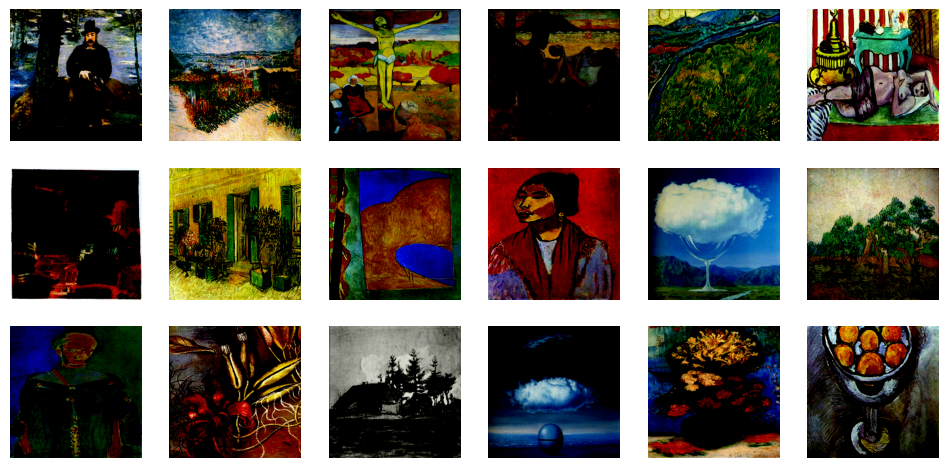

In [9]:
np.random.shuffle(images)

fig = plt.figure(figsize=(12,12))
for i in range(1,19):
    fig.add_subplot(6,6,i)
    plt.imshow(images[i])
    plt.axis('off')

## Generator structure

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.layers import Conv2DTranspose, Conv2D

def build_generator(seed_size=512, channels=3):
    model = Sequential()

    # Livello denso iniziale
    model.add(Dense(7 * 7 * 1024, activation="relu", input_dim=seed_size))
    model.add(Reshape((7, 7, 1024)))

    # Primo upsampling -> 14x14
    model.add(Conv2DTranspose(1024, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))  # Aggiunto Dropout

    # Secondo upsampling -> 28x28
    model.add(Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))  # Aggiunto Dropout

    # Terzo upsampling -> 56x56
    model.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    # Quarto upsampling -> 112x112
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    # Quinto upsampling -> 224x224
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    # Convoluzione finale per ridurre a 3 canali
    model.add(Conv2D(channels, kernel_size=3, padding="same", activation="tanh"))

    return model


In [ ]:
"""
def build_generator(seed_size=512, channels=3):
    model = Sequential()

    model.add(Dense(7 * 7 * 1024, activation="relu", input_dim=seed_size))  # 7 * 7 * 1024
    model.add(Reshape((7, 7, 1024)))  # La dimensione iniziale sarà (7, 7, 1024)

    # UpSampling2D 14x14
    model.add(UpSampling2D())
    model.add(Conv2D(1024, kernel_size=3, padding="same"))  # 1024 filtri
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    # UpSampling2D 28x28
    model.add(UpSampling2D())
    model.add(Conv2D(512, kernel_size=3, padding="same"))  # Ridotto a 512 filtri
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    # UpSampling2D 56x56
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding="same"))  # Ridotto a 256 filtri
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    # UpSampling2D 112x112
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))  # Ridotto a 128 filtri
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    # UpSampling2D 224x224
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(64, kernel_size=3, padding="same"))  # Ridotto a 64 filtri
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    return model
    """

'\ndef build_generator(seed_size=512, channels=3):\n    model = Sequential()\n\n    model.add(Dense(7 * 7 * 1024, activation="relu", input_dim=seed_size))  # 7 * 7 * 1024\n    model.add(Reshape((7, 7, 1024)))  # La dimensione iniziale sarà (7, 7, 1024)\n\n    # UpSampling2D 14x14\n    model.add(UpSampling2D())\n    model.add(Conv2D(1024, kernel_size=3, padding="same"))  # 1024 filtri\n    model.add(BatchNormalization(momentum=0.8))\n    model.add(Activation("relu"))\n\n    # UpSampling2D 28x28\n    model.add(UpSampling2D())\n    model.add(Conv2D(512, kernel_size=3, padding="same"))  # Ridotto a 512 filtri\n    model.add(BatchNormalization(momentum=0.8))\n    model.add(Activation("relu"))\n\n    # UpSampling2D 56x56\n    model.add(UpSampling2D())\n    model.add(Conv2D(256, kernel_size=3, padding="same"))  # Ridotto a 256 filtri\n    model.add(BatchNormalization(momentum=0.8))\n    model.add(Activation("relu"))\n\n    # UpSampling2D 112x112\n    model.add(UpSampling2D())\n    model.add(C

## Discriminator structure

In [11]:

def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(1, activation='sigmoid'))

    return model


In [ ]:
"""
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(1024, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(1, activation='sigmoid'))

    return model
"""

'\ndef build_discriminator(image_shape):\n    model = Sequential()\n\n    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))\n    model.add(LeakyReLU(alpha=0.2))\n    model.add(Dropout(0.25))\n\n    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))\n    model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))\n    model.add(BatchNormalization(momentum=0.8))\n    model.add(LeakyReLU(alpha=0.2))\n    model.add(Dropout(0.25))\n\n    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))\n    model.add(BatchNormalization(momentum=0.8))\n    model.add(LeakyReLU(alpha=0.2))\n    model.add(Dropout(0.25))\n\n    model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))\n    model.add(BatchNormalization(momentum=0.8))\n    model.add(LeakyReLU(alpha=0.2))\n    model.add(Dropout(0.25))\n\n    model.add(Conv2D(1024, kernel_size=3, strides=2, padding="same"))\n    model.add(BatchNormalization(momentum=0.8))\n    model.add(LeakyReLU(alp

## Settings

In [12]:
SEED_SIZE = 512
IMAGE_CHANNELS = 3

generator = build_generator(SEED_SIZE,IMAGE_CHANNELS)

noise = tf.random.normal([1,SEED_SIZE])
generated_image = generator(noise,training=False)

image_shape = (IMG_SIZE, IMG_SIZE, IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print(decision)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[0.4999888]], shape=(1, 1), dtype=float32)


In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1.2e-4, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.2e-4, 0.5)

In [14]:
GENERATED_ROWS = 7
GENERATED_COLS = 7
MARGIN = 2

def save_images(cnt, noise):
    image_array = np.full((
      2 + (7 * (IMG_SIZE + 2)),
      2 + (7 * (IMG_SIZE + 2)), 3),
      0, dtype=np.uint8)

    generated_images =  generator.predict(noise)

    image_count = 0
    for row in range(GENERATED_ROWS):
        for col in range(GENERATED_COLS):
            r = row * (IMG_SIZE + 2) + MARGIN
            c = col * (IMG_SIZE + 2) + MARGIN
            image_array[r:r+IMG_SIZE , c:c+IMG_SIZE] = generated_images[image_count] * 127.5 + 127.5
            image_count += 1

    output_path  = os.path.join("content/generated/")
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    filename = os.path.join(output_path,f"train-{cnt}.png")
    im = Image.fromarray(image_array)
    im.save(filename)

## Training

In [15]:
BATCH_SIZE = 64
epoch_counter = tf.Variable(0, trainable=False, dtype=tf.int32)
best_gen_loss = tf.Variable(float('inf'), trainable=False)

@tf.function
def train_step(images):
    seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(seed, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(
            gen_loss,
            generator.trainable_variables
        )
        gradients_of_discriminator = disc_tape.gradient(
            disc_loss,
            discriminator.trainable_variables
        )

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    real_accuracy = tf.reduce_mean(tf.cast(real_output > 0.5, tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(fake_output < 0.5, tf.float32))
    disc_accuracy = (real_accuracy + fake_accuracy) / 2.0

    # Entropy of style
    real_entropy = -tf.reduce_sum(
        tf.nn.softmax(real_output) * tf.nn.log_softmax(real_output), axis=1
    )
    fake_entropy = -tf.reduce_sum(
        tf.nn.softmax(fake_output) * tf.nn.log_softmax(fake_output), axis=1
    )
    disc_entropy = (tf.reduce_mean(real_entropy) + tf.reduce_mean(fake_entropy)) / 2.0

    return gen_loss, disc_loss, disc_accuracy, disc_entropy

In [16]:
import numpy as np
import tensorflow as tf

EPOCHS = 250

patience = 5
factor = 0.5
min_lr = 1e-7
best_loss = tf.Variable(float('inf'), trainable=False)
epochs_no_improve = tf.Variable(0, trainable=False)

def adjust_learning_rate(gen_loss, disc_loss):
    global best_loss, epochs_no_improve

    current_loss = gen_loss + disc_loss

    if current_loss < best_loss:
        best_loss.assign(current_loss)
        epochs_no_improve.assign(0)
    else:
        epochs_no_improve.assign_add(1)

    if epochs_no_improve >= patience:
        new_lr = max(generator_optimizer.learning_rate.numpy() * factor, min_lr)
        generator_optimizer.learning_rate.assign(new_lr)
        discriminator_optimizer.learning_rate.assign(new_lr)
        epochs_no_improve.assign(0)  # reset counter

        print(f"Learning rate reduced to {new_lr:.6f} after {patience} epochs without improvements.")

def train_process(dataset, epochs):
    global best_gen_loss

    history = {
        'gen_loss': [],
        'disc_loss': [],
        'disc_accuracy': [],
        'disc_entropy': []
    }

    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []
        disc_acc_list = []
        disc_entropy_list = []

        for image_batch in dataset:
            gen_loss, disc_loss, disc_accuracy, disc_entropy = train_step(image_batch)
            gen_loss_list.append(gen_loss)
            disc_loss_list.append(disc_loss)
            disc_acc_list.append(disc_accuracy)
            disc_entropy_list.append(disc_entropy)

        g_loss = np.mean([x.numpy() for x in gen_loss_list])
        d_loss = np.mean([x.numpy() for x in disc_loss_list])
        d_acc = np.mean([x.numpy() for x in disc_acc_list])
        d_entropy = np.mean([x.numpy() for x in disc_entropy_list])

        print(f"Epoch {epoch+1}, gen loss = {g_loss:.4f}, disc loss = {d_loss:.4f}, disc accuracy = {d_acc:.4f}, disc entropy = {d_entropy:.4f}")

        history['gen_loss'].append(g_loss)
        history['disc_loss'].append(d_loss)
        history['disc_accuracy'].append(d_acc)
        history['disc_entropy'].append(d_entropy)


        if g_loss < best_gen_loss.numpy():
            best_gen_loss.assign(g_loss)
            generator.save_weights("weights/generator_best.weights.h5")
            discriminator.save_weights("weights/discriminator_best.weights.h5")
            print(f"New improvement! Weights saved (gen_loss: {g_loss:.4f})")

        # Adjust learning rate
        adjust_learning_rate(g_loss, d_loss)

        save_images(epoch, np.random.normal(0, 1, (GENERATED_ROWS * GENERATED_COLS, SEED_SIZE)))

    return history

dataset = tf.data.Dataset.from_tensor_slices(images).batch(BATCH_SIZE)

history = train_process(dataset, EPOCHS)

Epoch 1, gen loss = 0.7424, disc loss = 1.9261, disc accuracy = 0.4327, disc entropy = 0.0000
New improvement! Weights saved (gen_loss: 0.7424)
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step
Epoch 2, gen loss = 1.1223, disc loss = 1.3701, disc accuracy = 0.6554, disc entropy = 0.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Epoch 3, gen loss = 1.4201, disc loss = 1.0917, disc accuracy = 0.7756, disc entropy = 0.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Epoch 4, gen loss = 1.9388, disc loss = 0.7004, disc accuracy = 0.8733, disc entropy = 0.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Epoch 5, gen loss = 1.6251, disc loss = 1.1766, disc accuracy = 0.7260, disc entropy = 0.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Epoch 6, gen loss = 1.5511, disc loss = 0.9927, disc accuracy = 0.7532, disc entropy = 0.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Epoch 7, gen loss = 1.6834, disc loss = 1.0275, disc accuracy = 0.7650, disc entropy = 0.0000
Learning rate reduced to 0.000060 after 5 epochs without improvem

KeyboardInterrupt: 

## Results

In [17]:
def plot_history(history):
    epochs = range(1, len(history['gen_loss']) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['gen_loss'], label='Generator Loss')
    plt.plot(epochs, history['disc_loss'], label='Discriminator Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['disc_accuracy'], label='Discriminator Accuracy', color='green')
    plt.title('Discriminator Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

NameError: name 'history' is not defined

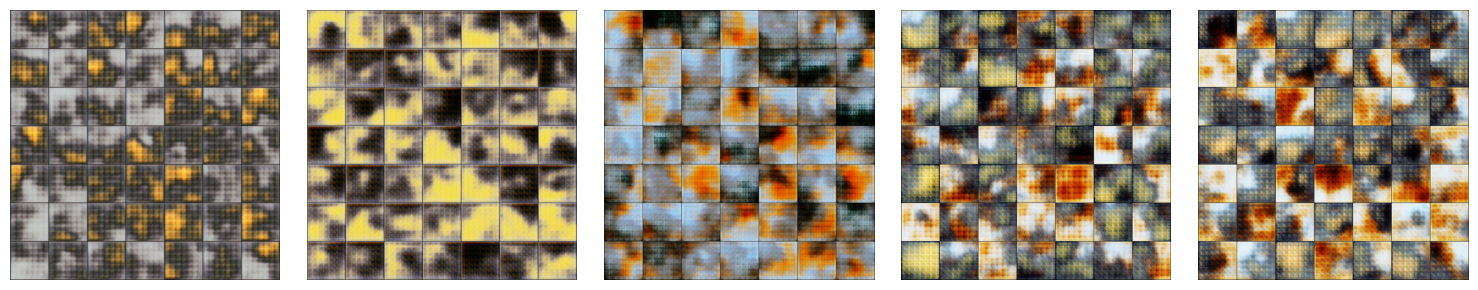

In [20]:
import matplotlib.pyplot as plt
from PIL import Image

def display_saved_images(paths, rows=1, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    for ax, path in zip(axes.flatten(), paths):
        img = Image.open(path)
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

image_paths = [f"./content/generated/train-{i}.png" for i in range(0, EPOCHS)]

selected_paths = [image_paths[i] for i in [10, 20, 30, 40, 49]]

display_saved_images(selected_paths, rows=1, cols=5)

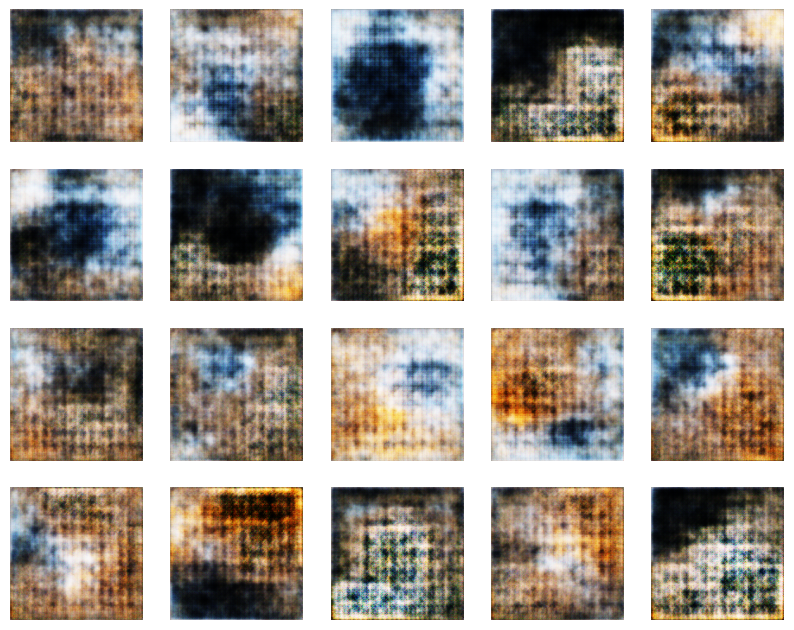

In [21]:
# Generate final images
seed2 = tf.random.normal([BATCH_SIZE, SEED_SIZE])
generated_images2 = generator(seed2, training=True)
generated_images2 = 0.5 * generated_images2 + 0.5

# Display generated images
fig = plt.figure(figsize=(10, 10))
for i in range(1, 21):
    fig.add_subplot(5, 5, i)
    plt.imshow(generated_images2[i])
    plt.axis('off')
plt.show()